In [3]:
import pymysql
import pymysql.cursors
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#connect my database

In [5]:
mydb = pymysql.connect(
    host='127.0.0.1',
    port=3306,
    user='root',
    passwd='',
    db='action'
    )

In [4]:
#merge table information

In [63]:
cursor=mydb.cursor()
all_info_table_train='CREATE TABLE all_info_table_train AS\
                SELECT P.cate,A.user_id,A.sku_id,A.action_time,P.brand,P.shop_id,A.type,U.sex,U.age,U.user_lv_cd,U.city_level\
                FROM action AS A\
                JOIN product AS P ON P.sku_id=A.sku_id\
                JOIN user AS U ON U.user_id=A.user_id\
                WHERE A.type=2 AND A.action_time BETWEEN "2018-02-01 00:00:00" AND "2018-04-10 00:00:00"'
cursor.execute(all_info_table_train)
myresult_train=cursor.fetchall()

In [64]:
cursor2=mydb.cursor()
all_info_table_test='CREATE TABLE all_info_table_test AS\
                SELECT P.cate,A.user_id,A.sku_id,A.action_time,P.brand,P.shop_id,A.type,U.sex,U.age,U.user_lv_cd,U.city_level\
                FROM action AS A\
                JOIN product AS P ON P.sku_id=A.sku_id\
                JOIN user AS U ON U.user_id=A.user_id\
                WHERE A.type=2 AND A.action_time BETWEEN "2018-04-10 00:00:00" AND "2018-04-16 00:00:00"'
cursor2.execute(all_info_table_test)
myresult_test=cursor.fetchall()

In [18]:
cursor.close()

In [6]:
top10_all_info_table_train='SELECT *\
                            FROM all_info_table_train\
                            limit 10'
sql_top_10_all_info_table_train=pd.read_sql_query(top10_all_info_table_train,mydb)
print(sql_top_10_all_info_table_train)

   cate  user_id  sku_id            action_time  brand  shop_id  type  sex  \
0    79   660257  282037  2018-02-08 15:05:37.0   4854     5338     2  1.0   
1    79  1008776   31647  2018-03-02 01:02:08.0  10511     9665     2  0.0   
2    79  1569797  141162  2018-02-06 22:32:30.0   4854       79     2  1.0   
3    79  1066676  102904  2018-03-08 10:22:09.0   1226     7129     2  1.0   
4    79  1314628  102417  2018-02-05 11:47:45.0   5700     1553     2  1.0   
5    79   982912  264665  2018-02-18 16:19:44.0   1898     1182     2  0.0   
6    79   260858  307497  2018-02-01 19:29:26.0   5206     9665     2  0.0   
7    79  1123179  274889  2018-03-18 16:26:49.0   2564     6710     2  1.0   
8    79   148013   47151  2018-02-21 18:48:56.0   2564     1095     2  1.0   
9    79   399810  270064  2018-03-04 11:47:11.0   4361     5896     2  1.0   

   age  user_lv_cd city_level  
0  5.0           1             
1  6.0           7        4.0  
2  5.0           5        4.0  
3  6.0       

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy import stats
from copy import deepcopy
import csv
import os

In [8]:
#load dataset

In [9]:
train_df=pd.read_csv('/Users/charles/Desktop/consumer/all_info_table_train.csv')
test_df=pd.read_csv('/Users/charles/Desktop/consumer/all_info_table_test.csv')

In [10]:
train_df.head(5)

,cate,user_id,sku_id,action_time,brand,shop_id,type,sex,age,user_lv_cd,city_level
0,79,660257,282037,2018-02-08 15:05:37.0,4854,5338,2,1.0,5.0,1,NaN
1,79,1008776,31647,2018-03-02 01:02:08.0,10511,9665,2,0.0,6.0,7,4.0
2,79,1569797,141162,2018-02-06 22:32:30.0,4854,79,2,1.0,5.0,5,4.0
3,79,1066676,102904,2018-03-08 10:22:09.0,1226,7129,2,1.0,6.0,7,1.0
4,79,1314628,102417,2018-02-05 11:47:45.0,5700,1553,2,1.0,5.0,5,1.0


In [11]:
test_df.head(5)

,cate,user_id,sku_id,action_time,brand,shop_id,type,sex,age,user_lv_cd,city_level
0,79,537520,58984,2018-04-14 18:44:53.0,2564,1095,2,NaN,NaN,5,NaN
1,19,1195693,261922,2018-04-14 17:48:01.0,7357,4059,2,1.0,5.0,1,NaN
2,27,1074877,134144,2018-04-10 16:15:11.0,6588,3663,2,0.0,5.0,7,1.0
3,79,158811,114345,2018-04-12 13:19:58.0,6574,4071,2,1.0,5.0,5,1.0
4,72,852571,219951,2018-04-10 23:18:54.0,3746,7196,2,-1.0,5.0,6,1.0


In [12]:
train_df.shape

(1978964, 11)

In [13]:
test_df.shape

(184682, 11)

In [14]:
train_df.describe()

,cate,user_id,sku_id,brand,shop_id,type,sex,age,user_lv_cd,city_level
count,1.978964e+06,1.978964e+06,1.978964e+06,1.978964e+06,1.978964e+06,1978964.0,1.978066e+06,1.976863e+06,1.978964e+06,1.977190e+06
mean,4.021845e+01,8.038331e+05,1.903919e+05,5.080010e+03,5.171412e+03,2.0,4.282981e-01,4.644960e+00,4.525498e+00,3.319738e+00
std,2.556868e+01,4.643364e+05,1.087221e+05,3.222402e+03,3.007510e+03,0.0,5.065627e-01,1.467262e+00,2.379927e+00,1.416239e+00
min,1.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,1.000000e+00,2.0,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.000000e+01,4.018278e+05,9.748900e+04,2.484000e+03,2.491000e+03,2.0,0.000000e+00,4.000000e+00,1.000000e+00,3.000000e+00
50%,3.400000e+01,8.035870e+05,1.889780e+05,4.491000e+03,5.172000e+03,2.0,0.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00
75%,6.900000e+01,1.206099e+06,2.856360e+05,7.954000e+03,7.831000e+03,2.0,1.000000e+00,6.000000e+00,6.000000e+00,4.000000e+00
max,8.100000e+01,1.608707e+06,3.784560e+05,1.119900e+04,1.039900e+04,2.0,1.000000e+00,6.000000e+00,7.000000e+00,6.000000e+00


In [15]:
#find null value

In [16]:
pd.isnull(train_df).values.any()

True

In [17]:
#there is existing null vaule in train dataset


In [18]:
#clean null values

In [19]:
pd.isnull(train_df['cate']).values.any()

False

In [20]:
pd.isnull(train_df['user_id']).values.any()

False

In [21]:
pd.isnull(train_df['sku_id']).values.any()

False

In [22]:
pd.isnull(train_df['brand']).values.any()

False

In [23]:
pd.isnull(train_df['shop_id']).values.any()

False

In [24]:
pd.isnull(train_df['sex']).values.any()

True

Text(0, 0.5, 'count')

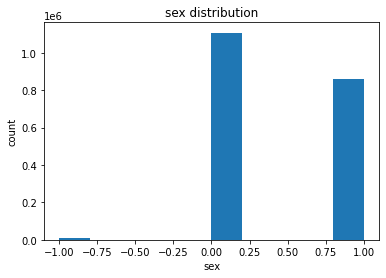

In [25]:
train_df['sex'].plot(kind='hist')
plt.title('sex distribution')
plt.xlabel('sex')
plt.ylabel('count')

In [26]:
pd.isnull(train_df['sex']).value_counts()

False    1978066
True         898
Name: sex, dtype: int64

In [27]:
#the number is small, we delete them directly

In [28]:
train_df.dropna(subset=['sex'],how='any',inplace=True)

In [29]:
pd.isnull(train_df['age']).value_counts()

False    1976863
True        1203
Name: age, dtype: int64

In [30]:
train_df.dropna(subset=['age'],how='any',inplace=True)

In [31]:
pd.isnull(train_df['user_lv_cd']).value_counts()

False    1976863
Name: user_lv_cd, dtype: int64

In [32]:
pd.isnull(train_df['city_level']).value_counts()

False    1975989
True         874
Name: city_level, dtype: int64

In [33]:
train_df.dropna(subset=['city_level'],how='any',inplace=True)

In [34]:
train_df.describe()

,cate,user_id,sku_id,brand,shop_id,type,sex,age,user_lv_cd,city_level
count,1.975989e+06,1.975989e+06,1.975989e+06,1.975989e+06,1.975989e+06,1975989.0,1.975989e+06,1.975989e+06,1.975989e+06,1.975989e+06
mean,4.022768e+01,8.038508e+05,1.903757e+05,5.081174e+03,5.170531e+03,2.0,4.291036e-01,4.645014e+00,4.524825e+00,3.319691e+00
std,2.556894e+01,4.643388e+05,1.087322e+05,3.222303e+03,3.007234e+03,0.0,5.055324e-01,1.467270e+00,2.380551e+00,1.416086e+00
min,1.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,1.000000e+00,2.0,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.000000e+01,4.018390e+05,9.745500e+04,2.484000e+03,2.491000e+03,2.0,0.000000e+00,4.000000e+00,1.000000e+00,3.000000e+00
50%,3.400000e+01,8.035930e+05,1.889230e+05,4.491000e+03,5.166000e+03,2.0,0.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00
75%,6.900000e+01,1.206128e+06,2.856360e+05,7.954000e+03,7.831000e+03,2.0,1.000000e+00,6.000000e+00,6.000000e+00,4.000000e+00
max,8.100000e+01,1.608707e+06,3.784560e+05,1.119900e+04,1.039900e+04,2.0,1.000000e+00,6.000000e+00,7.000000e+00,6.000000e+00


In [35]:
train_df.shape

(1975989, 11)

In [36]:
#Outliers

In [37]:
#statistic each product id sale in train set

Text(0, 0.5, 'sales')

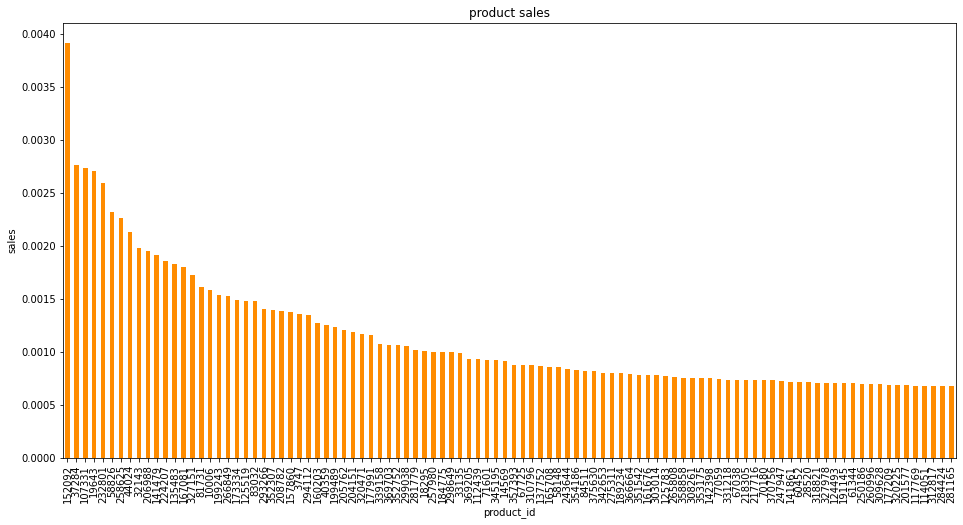

In [41]:
plt.figure(figsize=(16,8))
train_df['sku_id'].value_counts(normalize=True)[:100].plot(kind='bar',color='darkorange')
plt.title('product sales')
plt.xlabel('product_id')
plt.ylabel('sales')

In [42]:
train_df['sku_id'].value_counts(ascending=False)[:5]

152092    7724
37284     5457
107331    5407
19643     5341
232801    5126
Name: sku_id, dtype: int64

In [43]:
#product 152092 is much higher, we extract its records

In [44]:
train_df[train_df['sku_id']==152092]

,cate,user_id,sku_id,action_time,brand,shop_id,type,sex,age,user_lv_cd,city_level
9610,69,161965,152092,2018-03-13 11:55:12.0,5277,4005,2,1.0,5.0,5,5.0
9627,69,1092,152092,2018-03-29 17:08:11.0,5277,4005,2,0.0,6.0,6,4.0
9659,69,1204522,152092,2018-02-06 09:09:21.0,5277,4005,2,0.0,5.0,5,4.0
9661,69,333311,152092,2018-04-03 09:28:48.0,5277,4005,2,0.0,5.0,1,4.0
9670,69,640484,152092,2018-02-11 07:39:09.0,5277,4005,2,0.0,6.0,6,4.0
...,...,...,...,...,...,...,...,...,...,...,...
1972808,69,257777,152092,2018-03-23 13:43:13.0,5277,4005,2,1.0,6.0,6,1.0
1972846,69,508957,152092,2018-02-05 19:45:08.0,5277,4005,2,0.0,6.0,1,5.0
1972878,69,1337253,152092,2018-03-26 23:43:00.0,5277,4005,2,0.0,2.0,1,5.0
1972879,69,1022656,152092,2018-02-17 19:13:11.0,5277,4005,2,0.0,5.0,7,5.0


In [49]:
train_df['action_time']=pd.to_datetime(train_df['action_time']).dt.strftime('%Y%m%d')
train_df['action_time']

1          20180302
2          20180206
3          20180308
4          20180205
5          20180218
             ...   
1978959    20180403
1978960    20180304
1978961    20180312
1978962    20180313
1978963    20180211
Name: action_time, Length: 1975989, dtype: object

In [68]:
train_df[train_df['sku_id']==152092].value_counts('action_time')

action_time
20180328    380
20180312    272
20180204    253
20180228    214
20180205    193
           ... 
20180218     37
20180217     35
20180214     31
20180216     22
20180215     20
Length: 68, dtype: int64

Text(0, 0.5, 'sales')

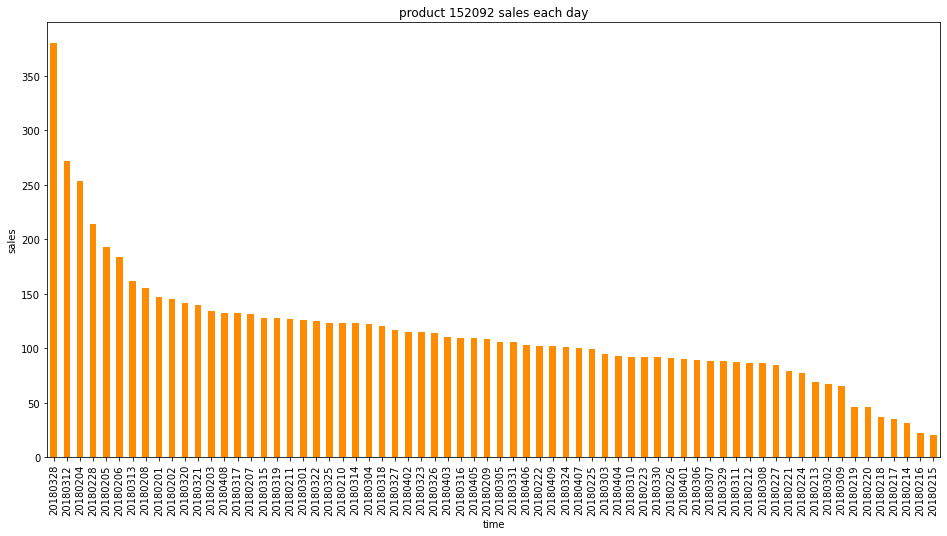

In [69]:
plt.figure(figsize=(16,8))
train_df[train_df['sku_id']==152092].value_counts('action_time').plot(kind='bar',color='darkorange')
plt.title('product 152092 sales each day')
plt.xlabel('time')
plt.ylabel('sales')

In [70]:
#we find that the sale of 2018-03-28 is higher

In [71]:
#we consider to delete the data

In [114]:
train_clear1=train_df.drop(train_df[(train_df['action_time']==20180328)&(train_df['sku_id']==152092)].index)

In [118]:
train_clear1.shape

(1975989, 11)

In [102]:
pd.isnull(train_clear1).values.any()

False

In [104]:
train_clear1['sku_id'].value_counts(ascending=True)[:10]

52710     1
351916    1
376496    1
368308    1
25092     1
29190     1
49680     1
53778     1
39451     1
66088     1
Name: sku_id, dtype: int64

In [119]:
#category sale distribution

Text(0, 0.5, 'sales')

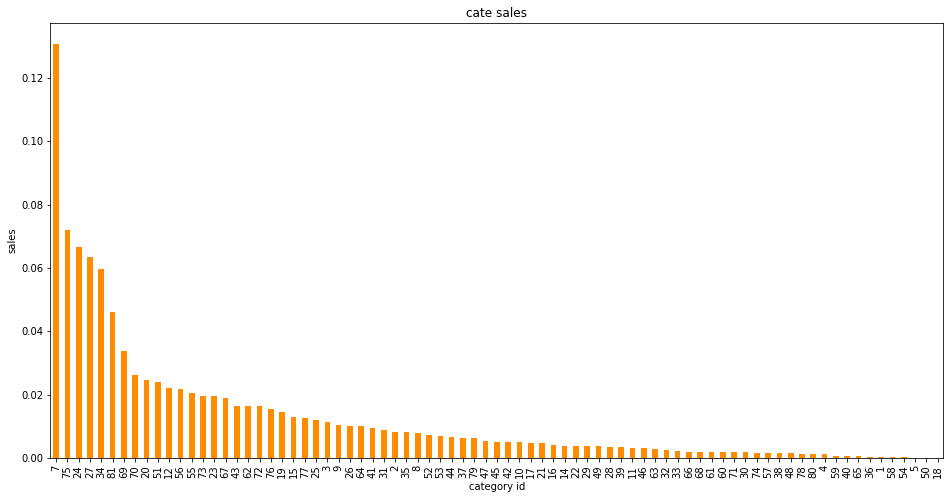

In [122]:
plt.figure(figsize=(16,8))
train_clear1['cate'].value_counts(normalize=True).plot(kind='bar',color='darkorange')
plt.title('cate sales')
plt.xlabel('category id')
plt.ylabel('sales')

In [ ]:
#skewness

In [127]:
stats.mstats.skew(train_clear1['cate'].value_counts(normalize=True)).data

array(3.43475203)

In [128]:
#skewness is 3.43, the data is skewed

In [130]:
stats.mstats.skew(np.log(train_clear1['cate'].value_counts(normalize=True))).data

array(-0.93560243)

Text(0, 0.5, 'sales')

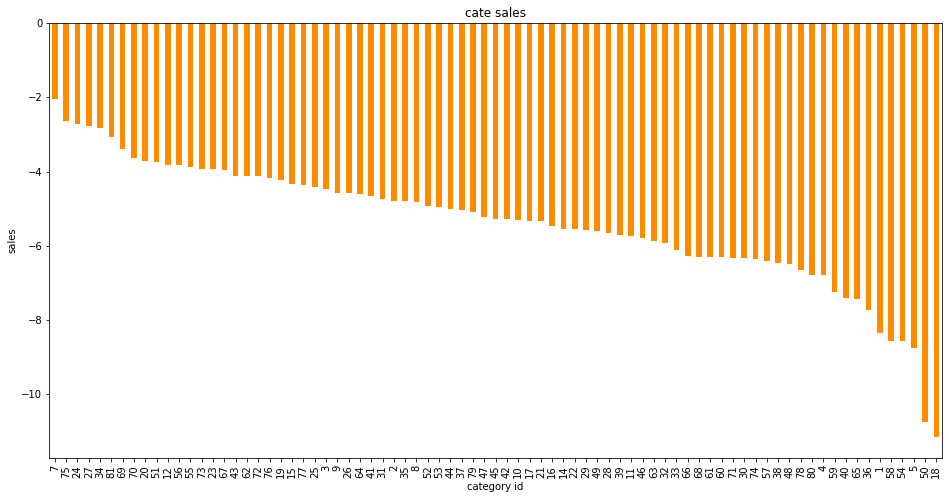

In [133]:
plt.figure(figsize=(16,8))
np.log(train_clear1['cate'].value_counts(normalize=True)).plot(kind='bar',color='darkorange')
plt.title('cate sales')
plt.xlabel('category id')
plt.ylabel('sales')

In [134]:
#corplot

<AxesSubplot:>

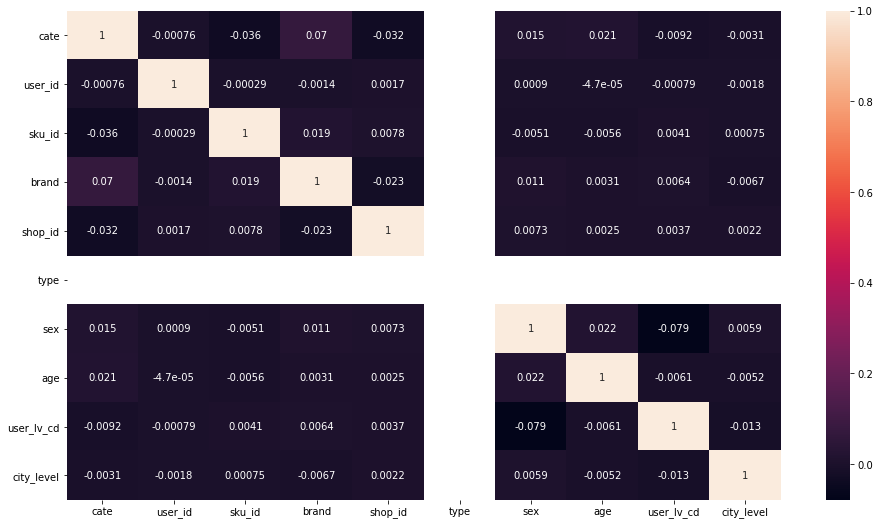

In [137]:
plt.subplots(figsize=(16,9))
correlation_mat=train_clear1.corr()
sns.heatmap(correlation_mat,annot=True)

In [148]:
train_clear2=train_clear1.drop(['type','sku_id'],axis=1)

In [149]:
train_clear2.shape

(1975989, 9)

In [163]:
#change action time to number representing

In [161]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_clear2['date_num'] = label_encoder.fit_transform(train_clear2['action_time'])

In [164]:
train_clear2

,cate,user_id,action_time,brand,shop_id,sex,age,user_lv_cd,city_level,date_num
1,79,1008776,20180302,10511,9665,0.0,6.0,7,4.0,29
2,79,1569797,20180206,4854,79,1.0,5.0,5,4.0,5
3,79,1066676,20180308,1226,7129,1.0,6.0,7,1.0,35
4,79,1314628,20180205,5700,1553,1.0,5.0,5,1.0,4
5,79,982912,20180218,1898,1182,0.0,5.0,5,1.0,17
...,...,...,...,...,...,...,...,...,...,...
1978959,3,254643,20180403,4854,5338,1.0,5.0,1,4.0,61
1978960,24,1233285,20180304,2540,4211,1.0,6.0,7,4.0,31
1978961,10,138926,20180312,8570,2738,0.0,5.0,6,5.0,39
1978962,45,118627,20180313,5309,7400,0.0,5.0,1,4.0,40


In [165]:
#drop action time column

In [166]:
train_clear3=train_clear2.drop(['action_time'],axis=1)

In [167]:
train_clear3

,cate,user_id,brand,shop_id,sex,age,user_lv_cd,city_level,date_num
1,79,1008776,10511,9665,0.0,6.0,7,4.0,29
2,79,1569797,4854,79,1.0,5.0,5,4.0,5
3,79,1066676,1226,7129,1.0,6.0,7,1.0,35
4,79,1314628,5700,1553,1.0,5.0,5,1.0,4
5,79,982912,1898,1182,0.0,5.0,5,1.0,17
...,...,...,...,...,...,...,...,...,...
1978959,3,254643,4854,5338,1.0,5.0,1,4.0,61
1978960,24,1233285,2540,4211,1.0,6.0,7,4.0,31
1978961,10,138926,8570,2738,0.0,5.0,6,5.0,39
1978962,45,118627,5309,7400,0.0,5.0,1,4.0,40
